In [1]:
import json 
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
# triples with original refs
# 30 dropout runs    
# each triple has mean and std score

#zeus

# f = open ('/media/hdd1/glushkovato/comet/segments.json', "r") 
# f = open ('/media/hdd1/glushkovato/comet/segments-fulltrain-dropout-01.json', "r") 
f = open('/media/hdd1/glushkovato/comet/segments-3hqref.json', 'r')


# - - - - - - - - - - - - - - - - 
# f = open ('/media/hdd1/glushkovato/comet/test-out.json', "r") 
# f = open ('/media/hdd1/glushkovato/comet/segments-arp-ref-norm.json', "r") 

data = json.loads(f.read()) 
f.close() 

In [3]:
data[0]

{'src': "Welsh AMs worried about 'looking like muppets'",
 'mt': 'Waliser AMs besorgt darüber, „wie Muppets auszusehen“',
 'ref': 'Walisische Abgeordnete befürchten als ,Idioten’ dazustehen.',
 'predicted_score_mean': -0.5830945799748103,
 'predicted_score_std': 0.17869798442810886}

In [4]:
# data[0]

In [5]:
lines = []
for i in data:
    lines.append([i['src'], i['mt'], i['ref'], i['predicted_score_mean'], i['predicted_score_std']])

In [6]:
df = pd.DataFrame(data=np.array(lines), 
                  columns=['src','mt', 'ref', 'predicted_score_mean','predicted_score_std'])

# df.iloc[:6]
df = df.iloc[::3, :]
df.iloc[:3]

,src,mt,ref,predicted_score_mean,predicted_score_std
0,Welsh AMs worried about 'looking like muppets',"Waliser AMs besorgt darüber, „wie Muppets ausz...","Walisische Abgeordnete befürchten als ,Idioten...",-0.5830945799748103,0.17869798442810886
3,There is consternation among some AMs at a sug...,Bei einigen AMs herrscht Bestürzung über einen...,Bei einigen AMs herrscht Fassungslosigkeit übe...,0.6151078684462441,0.09525737024885692
6,It has arisen because of plans to change the n...,"Sie ist aufgrund von Plänen entstanden, den Na...","Es kam wegen Plänen auf, den Namen der Versamm...",0.5645565691921446,0.1278485214320014


In [7]:
df.shape

(1997, 5)

In [8]:
df['predicted_score_std'].min()

'0.02860941847014708'

In [9]:
df['predicted_score_std'].max()

'1.0229324074726713'

In [10]:
da_scores = pd.read_csv('/media/hdd1/glushkovato/comet/COMET_uncertainty/data/da_scores_combined_ref.csv')
da_scores.iloc[:3]

,src,ref,extra_ref,Facebook_FAIR.6862,SID,raw_score,z_score,z_score_norm,raw_score_norm,annotators
0,Welsh AMs worried about 'looking like muppets',"Walisische Ageordnete sorgen sich ""wie Dödel a...","Walisische Abgeordnete befürchten als ,Idioten...","Waliser AMs besorgt darüber, „wie Muppets ausz...",0,NaN,NaN,NaN,NaN,NaN
1,There is consternation among some AMs at a sug...,Es herrscht Bestürzung unter einigen Mitgliede...,Bei einigen AMs herrscht Fassungslosigkeit übe...,Bei einigen AMs herrscht Bestürzung über einen...,1,96.5,0.696150,0.591311,0.410417,2.0
2,It has arisen because of plans to change the n...,"Der Grund dafür waren Pläne, den Namen der Nat...","Es kam wegen Plänen auf, den Namen der Versamm...","Sie ist aufgrund von Plänen entstanden, den Na...",2,68.0,-0.652806,-1.690535,-1.485173,1.0


In [11]:
df['z_score'] = da_scores['z_score'].tolist()
df['z_score_norm'] = da_scores['z_score_norm'].tolist()

cols = ['predicted_score_mean', 'predicted_score_std', 'z_score', 'z_score_norm']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [12]:
df.head()

,src,mt,ref,predicted_score_mean,predicted_score_std,z_score,z_score_norm
0,Welsh AMs worried about 'looking like muppets',"Waliser AMs besorgt darüber, „wie Muppets ausz...","Walisische Abgeordnete befürchten als ,Idioten...",-0.583095,0.178698,NaN,NaN
3,There is consternation among some AMs at a sug...,Bei einigen AMs herrscht Bestürzung über einen...,Bei einigen AMs herrscht Fassungslosigkeit übe...,0.615108,0.095257,0.696150,0.591311
6,It has arisen because of plans to change the n...,"Sie ist aufgrund von Plänen entstanden, den Na...","Es kam wegen Plänen auf, den Namen der Versamm...",0.564557,0.127849,-0.652806,-1.690535
9,AMs across the political spectrum are worried ...,AMs im gesamten politischen Spektrum sind beso...,Mitglieder aller Parteien der Nationalversamml...,0.326563,0.469173,-0.013827,-0.609661
12,"One Labour AM said his group was concerned ""it...","Ein Labour AM sagte, seine Gruppe sei besorgt,...","Ein Labour-Abgeordneter sagte, seine Gruppe se...",0.509106,0.080947,0.246498,-0.169304


In [13]:
df.shape

(1997, 7)

In [14]:
df = df.dropna()
df.shape

(1744, 7)

In [15]:
df['q-mu'] = np.abs(df['z_score'] - df['predicted_score_mean'])

In [16]:
df.head()

,src,mt,ref,predicted_score_mean,predicted_score_std,z_score,z_score_norm,q-mu
3,There is consternation among some AMs at a sug...,Bei einigen AMs herrscht Bestürzung über einen...,Bei einigen AMs herrscht Fassungslosigkeit übe...,0.615108,0.095257,0.696150,0.591311,0.081042
6,It has arisen because of plans to change the n...,"Sie ist aufgrund von Plänen entstanden, den Na...","Es kam wegen Plänen auf, den Namen der Versamm...",0.564557,0.127849,-0.652806,-1.690535,1.217363
9,AMs across the political spectrum are worried ...,AMs im gesamten politischen Spektrum sind beso...,Mitglieder aller Parteien der Nationalversamml...,0.326563,0.469173,-0.013827,-0.609661,0.340390
12,"One Labour AM said his group was concerned ""it...","Ein Labour AM sagte, seine Gruppe sei besorgt,...","Ein Labour-Abgeordneter sagte, seine Gruppe se...",0.509106,0.080947,0.246498,-0.169304,0.262608
15,For readers outside of Wales: In Welsh twp mea...,Für Leser außerhalb von Wales: Auf Walisisch b...,Für Leser außerhalb von Wales: Auf Walisisch b...,0.553397,0.226943,0.719816,0.631343,0.166419


In [17]:
z_scores = df['z_score'].tolist()
z_scores_norm = df['z_score_norm'].tolist()
mean_vals = df['predicted_score_mean'].tolist()
std_vals = df['predicted_score_std'].tolist()

In [18]:
print('min std: ', round(min(std_vals), 6))
print('max std: ', round(max(std_vals), 6))

min std:  0.028609
max std:  1.022932


## data plots

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Math, Latex
from IPython.core.display import Image
import seaborn as sns
sns.set(color_codes=True)

sns.set(rc={'figure.figsize':(10,5)}) # seaborn plot sizes

### test example

In [20]:
from scipy.stats import norm

# data_normal = norm.rvs(size=10000,loc=0,scale=1) # random numbers from N(0,1)

In [21]:
# ax = sns.distplot(sorted(data_normal),
#                   bins=100,
#                   kde=True,
#                   color='skyblue',
#                   hist_kws={"linewidth": 15,'alpha':1})
# ax.set(xlabel='Normal Distribution', ylabel='Frequency')

### our data

mean values for each triple

/media/hdd1/glushkovato/comet/py37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'mean_vals distribution'), Text(0, 0.5, 'Frequency')]

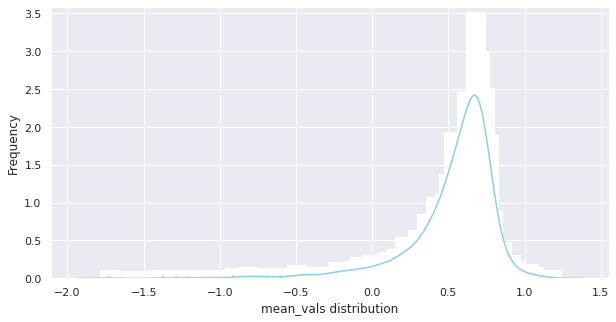

In [22]:
ax = sns.distplot(mean_vals,
                  bins=100,
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})

ax.set(xlabel='mean_vals distribution', ylabel='Frequency')

/media/hdd1/glushkovato/comet/py37_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'z_scores distribution'), Text(0, 0.5, 'Frequency')]

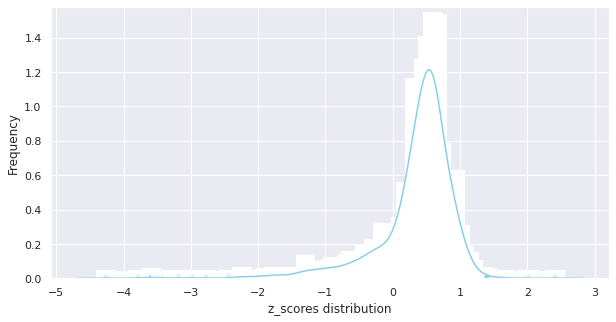

In [23]:
ax = sns.distplot(z_scores,
                  bins=100,
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})

ax.set(xlabel='z_scores distribution', ylabel='Frequency')

In [24]:
tmp_df = df[['predicted_score_mean', 'predicted_score_std', 'z_score', 'q-mu']]
tmp_df.columns = ['comet_mean', 'comet_std', 'da_score', '|da_score-comet_mean|']
tmp_df.head()

,comet_mean,comet_std,da_score,|da_score-comet_mean|
3,0.615108,0.095257,0.696150,0.081042
6,0.564557,0.127849,-0.652806,1.217363
9,0.326563,0.469173,-0.013827,0.340390
12,0.509106,0.080947,0.246498,0.262608
15,0.553397,0.226943,0.719816,0.166419


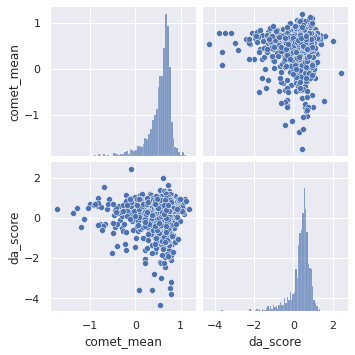

In [25]:
g = sns.pairplot(tmp_df[['comet_mean', 'da_score']])

In [26]:
tmp_df['comet_mean'].mean() 

0.5308905747398521

In [27]:
tmp_df['da_score'].mean()

0.34679193216427295

In [28]:
tmp_df['comet_mean'].min()

-1.7434382531378003

In [29]:
tmp_df['comet_mean'].max()

1.1905123750368751

In [30]:
tmp_df['da_score'].min()

-4.30188188115954

In [31]:
tmp_df['da_score'].max()

2.43796983116887

In [32]:
tmp_df['comet_std'].min()

0.028609418470147

In [33]:
tmp_df['comet_std'].max()

1.0229324074726711

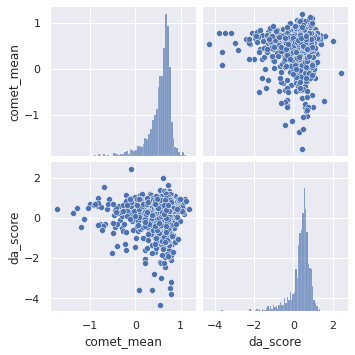

In [34]:
sns.pairplot(tmp_df[['comet_mean', 'da_score']])

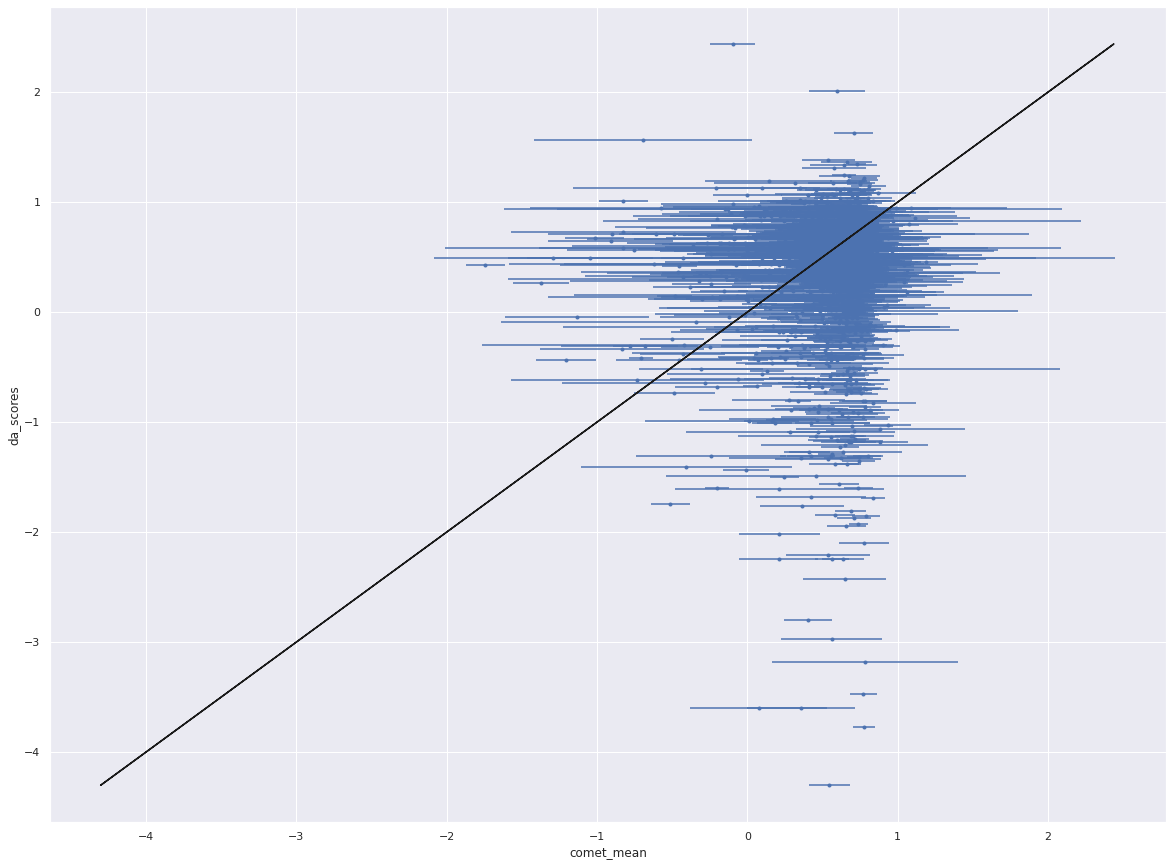

In [36]:
plt.figure(figsize=(20,15))

x = np.array(tmp_df['comet_mean'].tolist())
y = np.array(tmp_df['da_score'].tolist())
xerr = 2*np.array(tmp_df['comet_std'].tolist())

plt.plot(x,y,'b.') # x vs y
# plt.plot(x,x,'k-') # identity line
plt.plot(y,y,'k-') # identity line
# plt.errorbar(x, y, yaerr, marker='s', mfc='red', mec='green', ms=20, mew=4)
plt.errorbar(x, y, xerr=xerr, fmt='none')


# plt.xlim(-1,2)
# plt.ylim(-1,2)

plt.xlabel('comet_mean')
plt.ylabel('da_scores')
plt.show()

In [378]:
xerr.min()

0.057218836940294

In [379]:
xerr.max()

2.0458648149453422

In [ ]:
# comet_mean
# negative <= 0
# neutral >0 and <1
# positive >=1

# da_score
# negative <= 0
# neutral >0 and <1
# positive >=1

In [37]:
# comet_mean
min_thres = -0.5
max_thres = 0.8

In [38]:
# tmp_df[tmp_df.comet_mean <= 0].shape
print('negative')
negative_std = tmp_df[tmp_df.comet_mean <= min_thres].comet_std
print('min: ', tmp_df[tmp_df.comet_mean <= min_thres].comet_std.min())
print('max: ', tmp_df[tmp_df.comet_mean <= min_thres].comet_std.max())
print('avg: ', tmp_df[tmp_df.comet_mean <= min_thres].comet_std.mean())
print()

# tmp_df[tmp_df.comet_mean >= 1].shape
print('positive')
positive_std = tmp_df[tmp_df.comet_mean >= max_thres].comet_std
print('min: ', tmp_df[tmp_df.comet_mean >= max_thres].comet_std.min())
print('max: ', tmp_df[tmp_df.comet_mean >= max_thres].comet_std.max())
print('avg: ', tmp_df[tmp_df.comet_mean >= max_thres].comet_std.mean())
print()

a = tmp_df[tmp_df.comet_mean > min_thres]
a[a.comet_mean < 1].shape
# tmp_df[[tmp_df.comet_mean > 0 and tmp_df.comet_mean < 1]].shape

print('neutral')
neutral_std = a[a.comet_mean < max_thres].comet_std
print('min: ', a[a.comet_mean < max_thres].comet_std.min())
print('max: ', a[a.comet_mean < max_thres].comet_std.max())
print('avg: ', a[a.comet_mean < max_thres].comet_std.mean())
print()

negative
min:  0.0409148185598989
max:  0.4820694997132865
avg:  0.20094625420971082

positive
min:  0.0362593429907553
max:  0.6131385429293752
avg:  0.1355299739250601

neutral
min:  0.028609418470147
max:  1.0229324074726711
avg:  0.11837275551334754



[Text(0.5, 0, 'std value')]

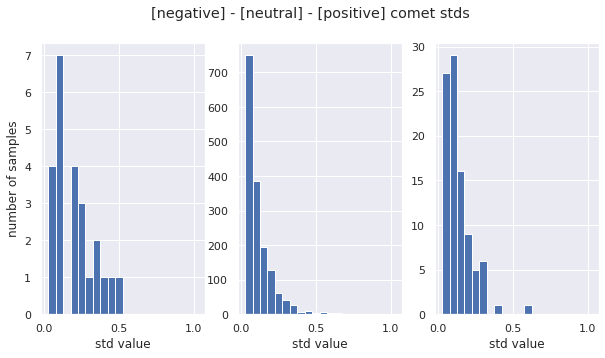

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('[negative] - [neutral] - [positive] comet stds')
ax1.hist(negative_std, range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
ax2.hist(neutral_std, range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
ax3.hist(positive_std, range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)

ax1.set(xlabel='std value', ylabel='number of samples')
ax2.set(xlabel='std value')
ax3.set(xlabel='std value')

In [40]:
# da_score
min_thres_da = -1
max_thres_da = 1.1

In [41]:
print('negative')
# tmp_df[tmp_df.comet_mean <= 0.3].shape
negative_std_da = tmp_df[tmp_df.da_score <= min_thres_da].comet_std
print('min: ', tmp_df[tmp_df.da_score <= min_thres_da].comet_std.min())
print('max: ', tmp_df[tmp_df.da_score <= min_thres_da].comet_std.max())
print('avg: ', tmp_df[tmp_df.da_score <= min_thres_da].comet_std.mean())
print()

print('positive')
# tmp_df[tmp_df.comet_mean >= 1].shape
positive_std_da = tmp_df[tmp_df.da_score >= max_thres_da].comet_std
print('min: ', tmp_df[tmp_df.da_score >= max_thres_da].comet_std.min())
print('max: ', tmp_df[tmp_df.da_score >= max_thres_da].comet_std.max())
print('avg: ', tmp_df[tmp_df.da_score >= max_thres_da].comet_std.mean())
print()

a = tmp_df[tmp_df.da_score > min_thres_da]
a[a.da_score < 1].shape
# tmp_df[[tmp_df.comet_mean > 0 and tmp_df.comet_mean < 1]].shape
print('neutral')
neutral_std_da = a[a.da_score < max_thres_da].comet_std
print('min: ', a[a.da_score < max_thres_da].comet_std.min())
print('max: ', a[a.da_score < max_thres_da].comet_std.max())
print('mean: ', a[a.da_score < max_thres_da].comet_std.mean())
print()

negative
min:  0.0325548438443439
max:  0.4999162449788722
avg:  0.12235322477977013

positive
min:  0.0301597483573259
max:  0.475768538830487
avg:  0.10269783066858043

neutral
min:  0.028609418470147
max:  1.0229324074726711
mean:  0.12068873925771517



[Text(0.5, 0, 'std value')]

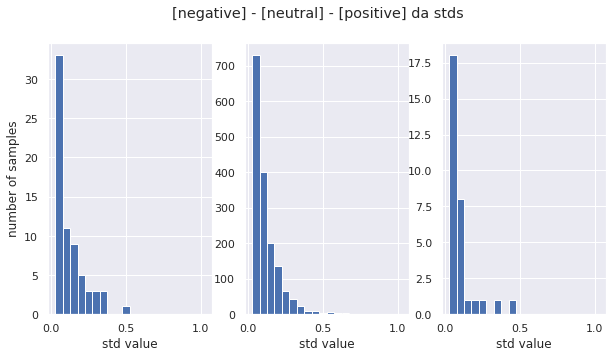

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('[negative] - [neutral] - [positive] da stds')
ax1.hist(negative_std_da, range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
ax2.hist(neutral_std_da, range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
ax3.hist(positive_std_da, range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)

ax1.set(xlabel='std value', ylabel='number of samples')
ax2.set(xlabel='std value')
ax3.set(xlabel='std value')


In [53]:
comet_splits = [negative_std, neutral_std, positive_std]
da_splits = [negative_std_da, neutral_std_da, positive_std_da]

comet_splits_names = ['negative_std', 'neutral_std', 'positive_std']
da_splits_names = ['negative_std_da', 'neutral_std_da', 'positive_std_da']

In [75]:
pairs = [(c, da) for c in comet_splits for da in da_splits]
pairs_names = [(c, da) for c in comet_splits_names for da in da_splits_names]

intersecs = []

for pair, name in zip(pairs, pairs_names):
    print(name)
    common_idx = pair[0].index.intersection(pair[1].index)
    common = pair[0].loc[common_idx]
    print('min: ', common.min())
    print('max: ', common.max())
    print('mean: ', common.mean())
    print('# samples: ', len(common))
    intersecs.append(common)
#     plt.hist(common, range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
#     plt.show()
    print()

# zip(pairs, pairs_names)

('negative_std', 'negative_std_da')
min:  0.0639646107259053
max:  0.0639646107259053
mean:  0.0639646107259053
# samples:  1

('negative_std', 'neutral_std_da')
min:  0.0409148185598989
max:  0.4820694997132865
mean:  0.19987134365929018
# samples:  22

('negative_std', 'positive_std_da')
min:  0.3615759298027702
max:  0.3615759298027702
mean:  0.3615759298027702
# samples:  1

('neutral_std', 'negative_std_da')
min:  0.0325548438443439
max:  0.4999162449788722
mean:  0.12445374519356048
# samples:  62

('neutral_std', 'neutral_std_da')
min:  0.028609418470147
max:  1.0229324074726711
mean:  0.11851309181082674
# samples:  1536

('neutral_std', 'positive_std_da')
min:  0.0301597483573259
max:  0.475768538830487
mean:  0.09720925861687449
# samples:  28

('positive_std', 'negative_std_da')
min:  0.0398673031089716
max:  0.2809925063020306
mean:  0.10798449445954258
# samples:  5

('positive_std', 'neutral_std_da')
min:  0.0362593429907553
max:  0.6131385429293752
mean:  0.1390769827242

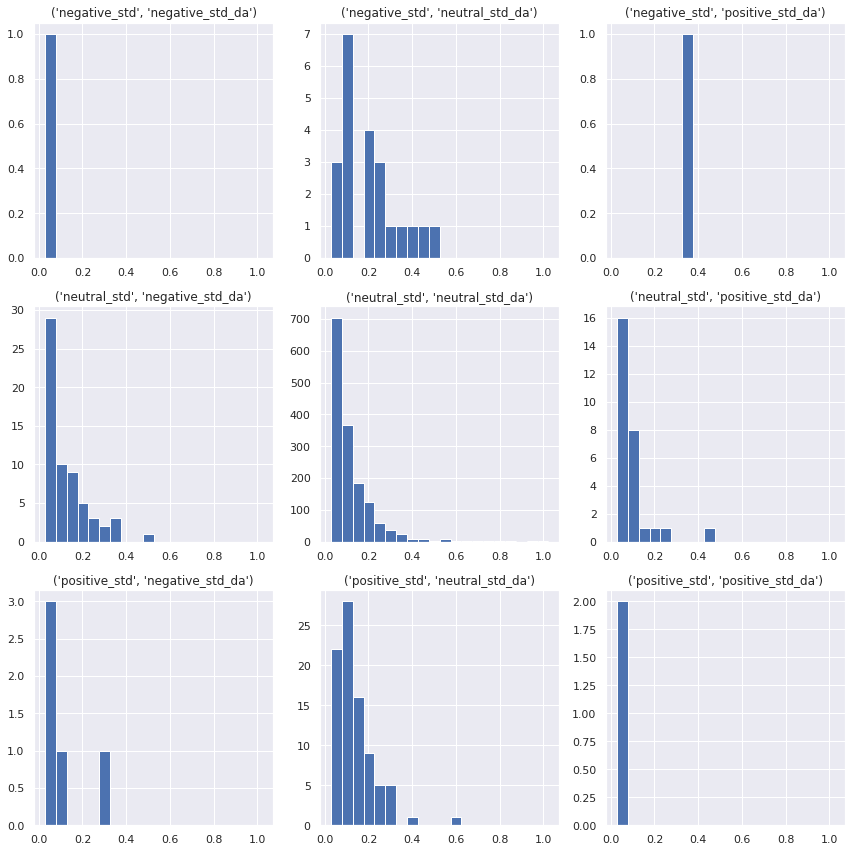

In [81]:
fig, axs = plt.subplots(3, 3, figsize=(12,12))
# fig.suptitle('[negative] - [neutral] - [positive] intersections')

axs[0,0].hist(intersecs[0], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[0,0].set_title(pairs_names[0])
axs[0,1].hist(intersecs[1], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[0,1].set_title(pairs_names[1])
axs[0,2].hist(intersecs[2], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[0,2].set_title(pairs_names[2])

axs[1,0].hist(intersecs[3], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[1,0].set_title(pairs_names[3])
axs[1,1].hist(intersecs[4], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[1,1].set_title(pairs_names[4])
axs[1,2].hist(intersecs[5], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[1,2].set_title(pairs_names[5])

axs[2,0].hist(intersecs[6], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[2,0].set_title(pairs_names[6])
axs[2,1].hist(intersecs[7], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[2,1].set_title(pairs_names[7])
axs[2,2].hist(intersecs[8], range=(tmp_df.comet_std.min(), tmp_df.comet_std.max()), bins=20)
axs[2,2].set_title(pairs_names[8])

fig.tight_layout()
# ax1.set(xlabel='std value', ylabel='number of samples')
# ax2.set(xlabel='std value')
# ax3.set(xlabel='std value')



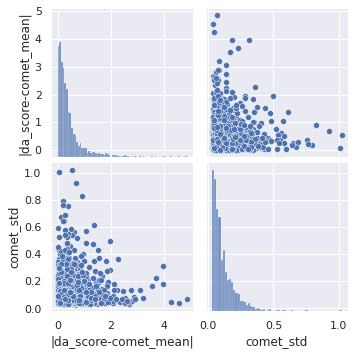

In [380]:
sns.pairplot(tmp_df[['|da_score-comet_mean|', 'comet_std']])


Text(0, 0.5, 'values')

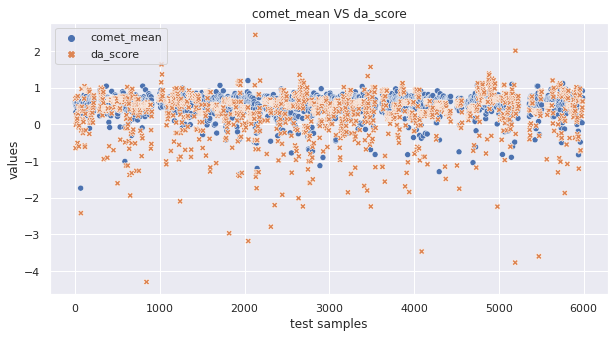

In [384]:
sns.scatterplot(data=tmp_df[['comet_mean', 'da_score']])
plt.title('comet_mean VS da_score')
plt.xlabel('test samples')
plt.ylabel('values')

Text(0, 0.5, 'values')

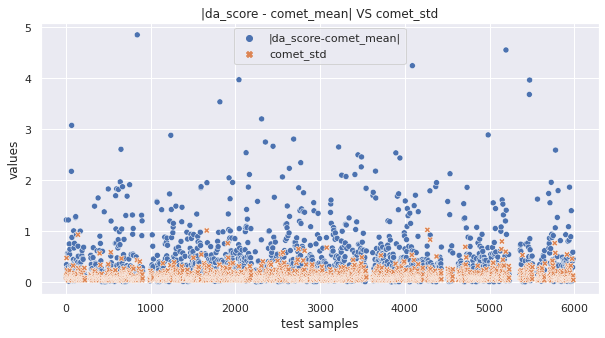

In [382]:
sns.scatterplot(data=tmp_df[['|da_score-comet_mean|', 'comet_std']])
plt.title('|da_score - comet_mean| VS comet_std')
plt.xlabel('test samples')
plt.ylabel('values')

## evaluation based on the log-likelihood metric  
log p(q | mu, sigma_sq) 


In [385]:
from scipy.stats import norm

In [386]:
mean = np.mean(mean_vals)
std = np.std(mean_vals)

In [387]:
np.min(std_vals)

0.028609418470147

In [388]:
np.max(std_vals)

1.0229324074726711

In [389]:
eps = np.finfo(float).eps # to avoid -inf when computing np.log(0)
eps

2.220446049250313e-16

In [390]:
tmp = []
probs = []
for i, q in enumerate(z_scores):
    prob = norm.pdf(q, mean_vals[i], std_vals[i])
    probs.append(prob)
    tmp.append(np.log(prob+eps))

In [391]:
np.sum(np.log(probs+eps))

-17928.876948654484

In [392]:
np.sum(np.log(probs+eps))

-17928.876948654484

In [393]:
np.sum(np.log(probs+eps))/len(probs) #! the value we want to compare (want: as big as possible) 
# z_scores and not norm comet

-10.28031935129271

In [93]:
# or as small as possible
np.abs(np.sum(np.log(probs+eps))/len(probs)) #! the value we want to compare 

22.17159822800405

In [394]:
from scipy.stats import norm
from scipy.stats import pearsonr

score_diff=[]
for zs, cs in zip(z_scores, mean_vals):
    score_diff.append(abs(zs - cs))
    
pearson_corr = pearsonr(score_diff, std_vals)
pearson_corr

(0.030035309101460114, 0.2099529403478373)

In [ ]:
# try norm.logpdf

In [147]:
norm.var(mean_vals[0],0.01)

0.0001

In [142]:
# var starting from 0.001 to 0.5, step 0.001
# find optomal std for a baseline

vals = []
for j in tqdm(np.arange(0.5, 0.8, 0.001)): 
    probs = []
    for i, q in enumerate(z_scores):
        prob = norm.pdf(q, mean_vals[i], j)
        probs.append(prob)
    vals.append(np.sum(np.log(probs+eps))/len(probs))

100%|██████████| 301/301 [00:53<00:00,  5.61it/s]


In [143]:
np.argmax(vals)

300

In [144]:
vals[np.argmax(vals)]

-1.6878358116439027

In [137]:
np.arange(0.001, 0.5, 0.001)[498]

0.499

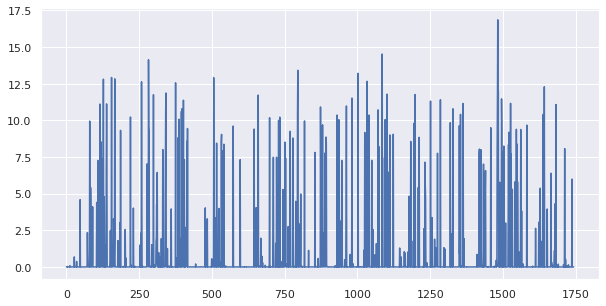

In [69]:
plt.plot(probs, color='b')

/media/hdd1/glushkovato/comet/py37_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


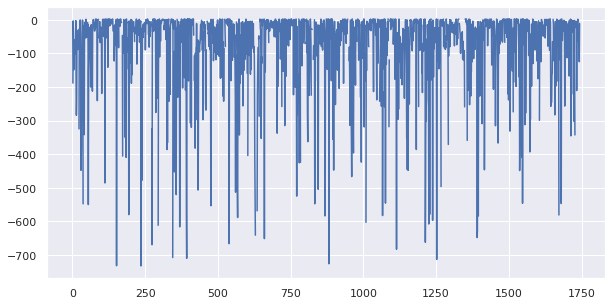

In [88]:
plt.plot(np.log(probs), color='b')

In [35]:
np.sum(tmp)

-37572.37062613824

In [74]:
np.log(norm.pdf(z_scores, mean, std))

array([  0.35527887, -10.78837592,  -2.41678263, ...,   0.38723281,
         0.18440155,   0.38723281])

In [72]:
np.log(norm.pdf(z_scores, mean, std)).sum()

-4415.865239777251

In [73]:
# np.log(norm.pdf(z_scores_norm, mean, std)).sum()

In [28]:
probs = norm.pdf(z_scores, mean, std)
probs

array([1.42657842e+00, 2.06380123e-05, 8.92081720e-02, ...,
       1.47289936e+00, 1.20249859e+00, 1.47289936e+00])

In [29]:
np.array(probs).any() >= 1

True

In [ ]:
probs

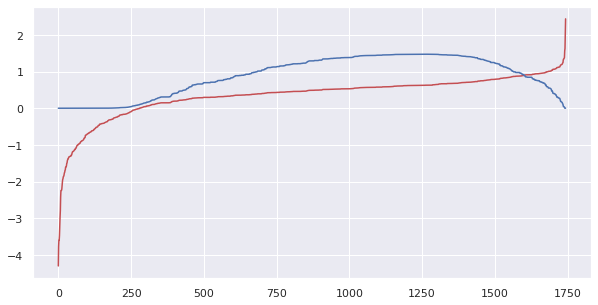

In [28]:
z_scores, probs = zip(*sorted(zip(z_scores, probs)))

plt.plot(z_scores, color='r')
plt.plot(probs, color='b')
# plt.plot(np.log(probs), color='g')
plt.show()

# positive-neutral-negative

		
DAs\comet	positive   neutral	negative       
positive	  <<	      >>	   >>      
neutral	      >>	      <<	   >>       
negative	  >>	      >>	   >>      



In [106]:
# comet_mean
# negative <= -1.5
# neutral >-1.5 and <1.5
# positive >=1.5

# da_score
# negative <= -1.5
# neutral >-1.5 and <1.5
# positive >=1.5

Freedman–Diaconis number of bins: 32


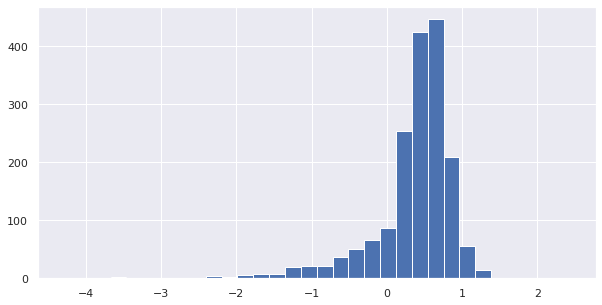

In [93]:
x = np.array(z_scores)
q25, q75 = np.percentile(x,[.25,.75])
bin_width = 2*(q75 - q25)*len(x)**(-1/3)
bins = round((x.max() - x.min())/bin_width)
print("Freedman–Diaconis number of bins:", bins)
plt.hist(x, bins = bins);

# plt.hist(z_scores)

In [104]:
len(x)

1744

In [101]:
((x<0)*1).sum()

280

In [105]:
((x>=0)*1).sum()

1464

Freedman–Diaconis number of bins: 61


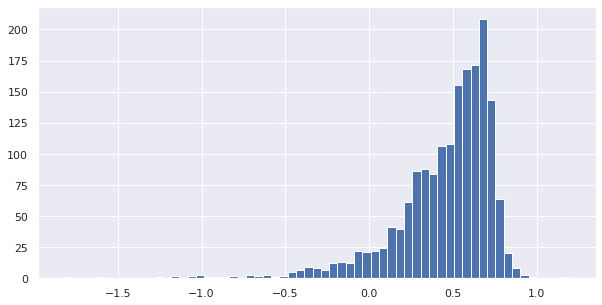

In [92]:
x = np.array(mean_vals)
q25, q75 = np.percentile(x,[.25,.75])
bin_width = 2*(q75 - q25)*len(x)**(-1/3)
bins = round((x.max() - x.min())/bin_width)
print("Freedman–Diaconis number of bins:", bins)
plt.hist(x, bins = bins);

# plt.hist(z_scores)